# Building basic search engine from scratch using Python, Sklearn, and Networkx
> A tutorial demonstrating how to implement basic search engine algorithm using Python, Sklearn, and Networkx 

- toc: true 
- comments: true
- categories: [python,search engine, sklearn,TFIDF,Network Analytics]

### Introduction
In the grad school classes (<i>Machine Learning for Business Managers, Network Analytics, Fintech, Data Driven Customer Management</i>) I took in my last few terms at B-school, I was introduced to Network Analytics and Google search algorithm in more detail.Search seemed like a perfect match of network analytics concepts like pagerank, eigenvector metrics and basic NLP algorithms I learned in the classes. Hence, in this post I implement a basic search engine using metrics such as eigenvector and TF-IDF. We use following Python libraries - Pandas, Sklearn, Networkx. 

### Data Source

We will implement search to find relevant TED talks based on user query. We will use data available on Kaggle - https://www.kaggle.com/rounakbanik/ted-talks.

It contains information about all audio-video recordings of TED Talks uploaded to the official TED.com website until September 21st, 2017. There are two CSV files 
<ol>
    <li> ted_main.csv - Contains data such as talk title, speaker, related talks </li>
    <li> transcripts.csv - Contains data such as talk transcripts and url </li>
</ol>

Ideally, our implemented search engine should give results similar to TED website search.

### Conceptual Overview

To provide search results, search engines like Google, Bing look at 3 distinct sources of information-
1. **Network Popularity: Citiation Model** - Google uses networks metrics such as pagerank (a variant of Eigenvector centrality network metric) which can be considered as the importance score of a web page. Web search engines use a crawler to create a network of web pages with hyperlinks b/w web pages as edges of the network. A web page (or network node) with high pagerank (or eigenvector centrality) is linked to other important network nodes. PageRank is defined recursively and depends on the number and PageRank metric of all pages that link to it ("incoming links"). A page that is linked to by many pages with high PageRank receives a high rank itself.

`![](img/PageRanks-Example.svg.png)`


<ul>
        <li><b>Network Popularity:Citiation Model</b> - Famously known as pagerank (Initially, Google search's competitive advantage over other search engines like Yahoo). Web search engines use a crawler to create a network of web pages where web pages cited by other important web pages have higher pagerank. For our purpose, we create a network (directed graph) of TED talks as nodes and a directed edge if destination TED talk is recommendation in source TED talk. We use eigenvector metric, pagerank is a variant of eigenvectors. We use Python Networkx library to build this. </li>

    <li><b>Content Relevance:Vector Model </b>- It looks at the relevance of content with search keywords. We will use an important metric Term Frequency-Inverse Document Frequency (TFIDF) to find out important words in the transcript data of the TED talks. More prominent are the search query words in a document higher is the TFIDF score.</li>
    <li><b>Behaviorial Data</b> - Metrics such as CTR (click through rate) and time spent on web page etc are also looked at.</li>

</ul>

<b> In this tutorial, we focus on the first 2 i.e. Content Relevance and Network Popularity. We have limited behaviorial data such as views, comments on TED videos. We will incorporate them in next version.</b>

### Imports
We use following libraries
<ul>
    <li>Networkx : <a>https://networkx.github.io/documentation/stable/</a></li>
    <li>Pandas : <a>https://pandas-docs.github.io/pandas-docs-travis/install.html</a></li>
    <li>Sklearn : <a>https://scikit-learn.org/stable/</a></li>
</ul>

In [90]:
#collapse-show
import networkx as nx
import pandas as pd
import os
import json
import ast
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from IPython.display import Image
from IPython.core.display import HTML 
pd.set_option('display.max_colwidth',1000)

### Data processing

<ul>
    <li>We load csv files, merge them and create a single dataframe</li>
    <li>As visible in the output below, final dataframe contains columns - title, transcript, url, and related talks</li>
    <li>There are 2467 TED talks</li>
</ul>

In [97]:
#collapse-show
path_to_data = os.getcwd() + "\\data\\"
ted_main_filepath = path_to_data + "ted_main.csv"
transcripts_filepath = path_to_data + "transcripts.csv"

ted_main_df = pd.read_csv(ted_main_filepath)
ted_main_df = ted_main_df[['title', 'url', 'related_talks']]
transcripts_df = pd.read_csv(transcripts_filepath)

#merge the two dataframes to create one. 
final_ted_df = transcripts_df.merge(ted_main_df, on="url")
final_ted_df = final_ted_df[['title', 'url', 'transcript', 'related_talks']]

print("We have data on {} talks. Notice the title, url, transcript, and related_talks columns below:".format(final_ted_df.shape[0]))
final_ted_df.head(2)

We have data on 2467 talks. Notice the title, url, transcrip, and related_talks columns below:


,title,url,transcript,related_talks
0,Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_schools_kill_creativity\n,"Good morning. How are you?(Laughter)It's been great, hasn't it? I've been blown away by the whole thing. In fact, I'm leaving.(Laughter)There have been three themes running through the conference which are relevant to what I want to talk about. One is the extraordinary evidence of human creativity in all of the presentations that we've had and in all of the people here. Just the variety of it and the range of it. The second is that it's put us in a place where we have no idea what's going to happen, in terms of the future. No idea how this may play out.I have an interest in education. Actually, what I find is everybody has an interest in education. Don't you? I find this very interesting. If you're at a dinner party, and you say you work in education — Actually, you're not often at dinner parties, frankly.(Laughter)If you work in education, you're not asked.(Laughter)And you're never asked back, curiously. That's strange to me. But if you are, and you say to somebody, you know, the...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/images/ted/172559_800x600.jpg', 'speaker': 'Ken Robinson', 'title': 'Bring on the learning revolution!', 'duration': 1008, 'slug': 'sir_ken_robinson_bring_on_the_revolution', 'viewed_count': 7266103}, {'id': 1738, 'hero': 'https://pe.tedcdn.com/images/ted/de98b161ad1434910ff4b56c89de71af04b8b873_1600x1200.jpg', 'speaker': 'Ken Robinson', 'title': ""How to escape education's death valley"", 'duration': 1151, 'slug': 'ken_robinson_how_to_escape_education_s_death_valley', 'viewed_count': 6657572}, {'id': 2276, 'hero': 'https://pe.tedcdn.com/images/ted/3821f3728e0b755c7b9aea2e69cc093eca41abe1_2880x1620.jpg', 'speaker': 'Linda Cliatt-Wayman', 'title': 'How to fix a broken school? Lead fearlessly, love hard', 'duration': 1027, 'slug': 'linda_cliatt_wayman_how_to_fix_a_broken_school_lead_fearlessly_love_hard', 'viewed_count': 1617101}, {'id': 892, 'hero': 'https://pe.tedcdn.com/images/ted/e79958940573cc610ccb583619a54866c41ef303_2880x1620.jpg', 's..."
1,Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_climate_crisis\n,"Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful. I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night. And I say that sincerely, partly because (Mock sob) I need that.(Laughter)Put yourselves in my position.(Laughter)I flew on Air Force Two for eight years.(Laughter)Now I have to take off my shoes or boots to get on an airplane!(Laughter)(Applause)I'll tell you one quick story to illustrate what that's been like for me.(Laughter)It's a true story — every bit of this is true.Soon after Tipper and I left the — (Mock sob) White House —(Laughter)we were driving from our home in Nashville to a little farm we have 50 miles east of Nashville. Driving ourselves.(Laughter)I know it sounds like a little thing to you, but —(Laughter)I looked in the rear-view mirror and all of a sudden it just hit me. There was no motorcade b...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/images/ted/566c14767bd62c5ff760e483c5b16cd2753328cd_2880x1620.jpg', 'speaker': 'Al Gore', 'title': 'New thinking on the climate crisis', 'duration': 1674, 'slug': 'al_gore_s_new_thinking_on_the_climate_crisis', 'viewed_count': 1751408}, {'id': 547, 'hero': 'https://pe.tedcdn.com/images/ted/89288_800x600.jpg', 'speaker': 'Ray Anderson', 'title': 'The business logic of sustainability', 'duration': 954, 'slug': 'ray_anderson_on_the_business_logic_of_sustainability', 'viewed_count': 881833}, {'id': 2093, 'hero': 'https://pe.tedcdn.com/images/ted/146d88845861cbf768bbf8bec8b2e41f8bfc7903_2400x1800.jpg', 'speaker': 'Lord Nicholas Stern', 'title': 'The state of the climate — and what we might do about it', 'duration'

### Calculating eigenvector value for each ted talk
<ul>
    <li> First, we need to create a directed graph where a node is a TED talk and an edge is - (source ted talk -> related ted talk). To create the graph we need a dataframe where each row represents an edge </li>
    <li> Then we get eigenvector values using networkx library function</li>
</ul>

In [94]:
#collapse-show
#Create edges dataframe which will be used to create directed graph
recommendations_df = final_ted_df[["title","related_talks"]]
def recommended_titles_list(reco_str):
    data = json.dumps(ast.literal_eval(reco_str))
    jdata = json.loads(data)
    titles_list = []
    for data in jdata:
        titles_list.append(data['title'])
    return titles_list

columns = ['title', 'related_title']
edges_df = pd.DataFrame(columns=columns)
for index, row in recommendations_df.iterrows():
    title = row['title']
    reco_list = recommended_titles_list(row['related_talks'])
    for reco_title in reco_list:
        edges_df = edges_df.append({'title':title, 'related_title':reco_title}, ignore_index=True)
print("In following dataframe each row represents an edge with total of {} edges:".format(edges_df.shape[0]))
edges_df.head(5)

In following dataframe each row represents an edge with total of 14802 edges:


,title,related_title
0,Do schools kill creativity?,Bring on the learning revolution!
1,Do schools kill creativity?,How to escape education's death valley
2,Do schools kill creativity?,"How to fix a broken school? Lead fearlessly, love hard"
3,Do schools kill creativity?,Education innovation in the slums
4,Do schools kill creativity?,A short intro to the Studio School


In [98]:
#collapse-show
# Create the directed graph from edges dataframe using networkx
di_reco_graph = nx.from_pandas_edgelist(edges_df,'title','related_title', create_using=nx.DiGraph())

# Calculate normalized eigenvector for nodes
eigenvector_dict = nx.eigenvector_centrality(di_reco_graph)

# normalize the eigenvectors
factor=1.0/sum(eigenvector_dict.values())
normalised_eigenvector_dict = {k: v*factor for k, v in eigenvector_dict.items() }

# Add the eigen vector values for each ted talk to the main dataframe
eigenvectors_df = pd.DataFrame(normalised_eigenvector_dict.items(), columns=['title', 'eigenvector_value'])
final_ted_df = final_ted_df.merge(eigenvectors_df,on=["title"])
print(nx.info(di_reco_graph))
print("Notice the last column having eigen_vector values for each TED talk : ")
final_ted_df.head(5)

Name: 
Type: DiGraph
Number of nodes: 2520
Number of edges: 14784
Average in degree:   5.8667
Average out degree:   5.8667
Notice the last column having eigen_vector values for each TED talk : 


,title,url,transcript,related_talks,eigenvector_value
0,Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_schools_kill_creativity\n,"Good morning. How are you?(Laughter)It's been great, hasn't it? I've been blown away by the whole thing. In fact, I'm leaving.(Laughter)There have been three themes running through the conference which are relevant to what I want to talk about. One is the extraordinary evidence of human creativity in all of the presentations that we've had and in all of the people here. Just the variety of it and the range of it. The second is that it's put us in a place where we have no idea what's going to happen, in terms of the future. No idea how this may play out.I have an interest in education. Actually, what I find is everybody has an interest in education. Don't you? I find this very interesting. If you're at a dinner party, and you say you work in education — Actually, you're not often at dinner parties, frankly.(Laughter)If you work in education, you're not asked.(Laughter)And you're never asked back, curiously. That's strange to me. But if you are, and you say to somebody, you know, the...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/images/ted/172559_800x600.jpg', 'speaker': 'Ken Robinson', 'title': 'Bring on the learning revolution!', 'duration': 1008, 'slug': 'sir_ken_robinson_bring_on_the_revolution', 'viewed_count': 7266103}, {'id': 1738, 'hero': 'https://pe.tedcdn.com/images/ted/de98b161ad1434910ff4b56c89de71af04b8b873_1600x1200.jpg', 'speaker': 'Ken Robinson', 'title': ""How to escape education's death valley"", 'duration': 1151, 'slug': 'ken_robinson_how_to_escape_education_s_death_valley', 'viewed_count': 6657572}, {'id': 2276, 'hero': 'https://pe.tedcdn.com/images/ted/3821f3728e0b755c7b9aea2e69cc093eca41abe1_2880x1620.jpg', 'speaker': 'Linda Cliatt-Wayman', 'title': 'How to fix a broken school? Lead fearlessly, love hard', 'duration': 1027, 'slug': 'linda_cliatt_wayman_how_to_fix_a_broken_school_lead_fearlessly_love_hard', 'viewed_count': 1617101}, {'id': 892, 'hero': 'https://pe.tedcdn.com/images/ted/e79958940573cc610ccb583619a54866c41ef303_2880x1620.jpg', 's...",0.003404
1,Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_climate_crisis\n,"Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful. I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night. And I say that sincerely, partly because (Mock sob) I need that.(Laughter)Put yourselves in my position.(Laughter)I flew on Air Force Two for eight years.(Laughter)Now I have to take off my shoes or boots to get on an airplane!(Laughter)(Applause)I'll tell you one quick story to illustrate what that's been like for me.(Laughter)It's a true story — every bit of this is true.Soon after Tipper and I left the — (Mock sob) White House —(Laughter)we were driving from our home in Nashville to a little farm we have 50 miles east of Nashville. Driving ourselves.(Laughter)I know it sounds like a little thing to you, but —(Laughter)I looked in the rear-view mirror and all of a sudden it just hit me. There was no motorcade b...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/images/ted/566c14767bd62c5ff760e483c5b16cd2753328cd_2880x1620.jpg', 'speaker': 'Al Gore', 'title': 'New thinking on the climate crisis', 'duration': 1674, 'slug': 'al_gore_s_new_thinking_on_the_climate_crisis', 'viewed_count': 1751408}, {'id': 547, 'hero': 'https://pe.tedcdn.com/images/ted/89288_800x600.jpg', 'speaker': 'Ray Anderson', 'title': 'The business logic of sustainability', 'duration': 954, 'slug': 'ray_anderson_on_the_business_logic_of_sustainability', 'viewed_count': 881833}, {'id': 2093, 'hero': 'https://pe.tedcdn.com/images/ted/146d88845861cbf768bbf8bec8b2e41f8bfc7903_2400x1800.jpg', 'speaker': 'Lord Nicholas Stern', 'title': 'The state of the climate — and what we mig

### Graph visualization using Gephi (https://gephi.org/)
<ul>
    <li> Gephi is a free software which provides GUI type interface to do network analytics and produce network metrics such as eigenvector and pagerank metrics.</li>
    <li>Following is a visual representation of our network graph with different colors representing different clusters or communities within graph. TED talks with similar themes or topic will tend to be in one cluster</li>
</ul>

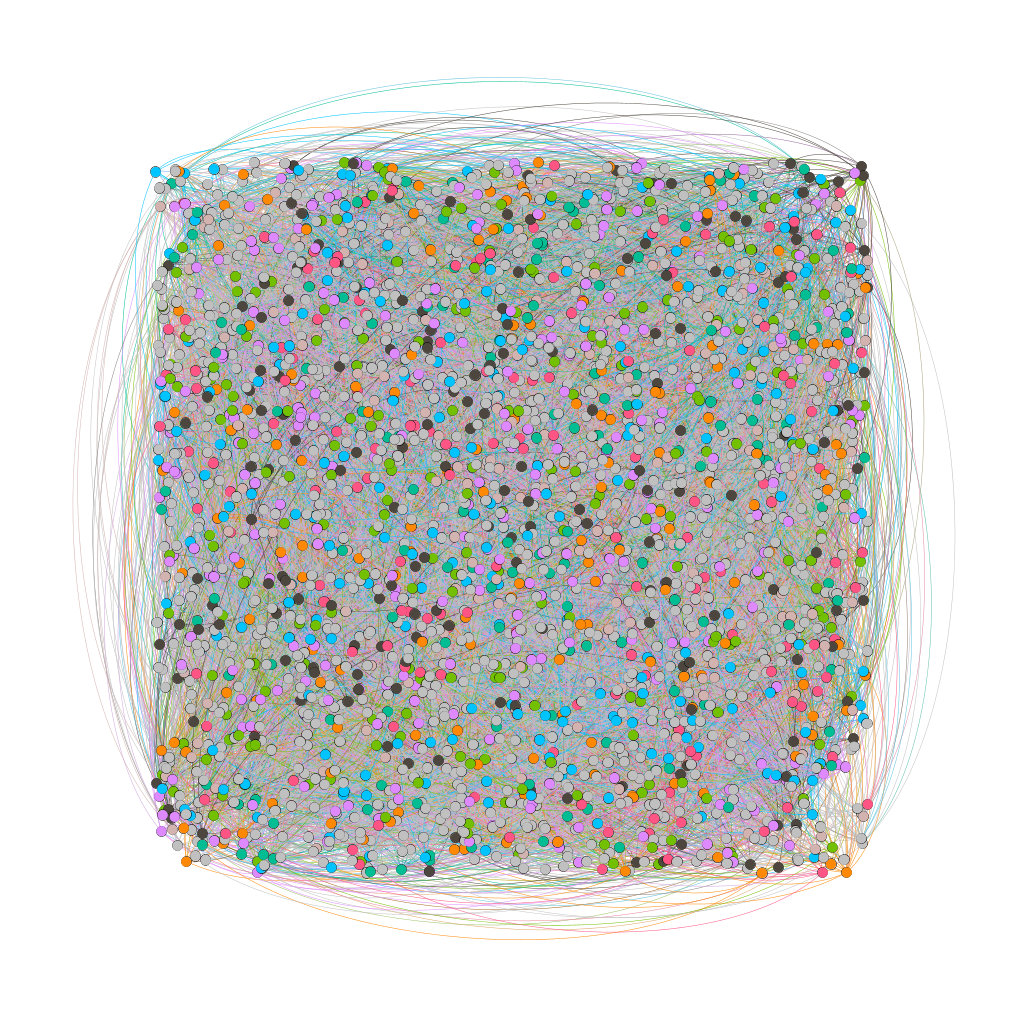

In [99]:
#hide_input
image_folder_path = os.getcwd() + "\\img\\"
# Following is the picture of directed graph
Image(filename = image_folder_path + "overall_graph.png", width=500, height=500)

#### For example, following is the graph of the biggest community in the above network representing talks related to technology and innovation

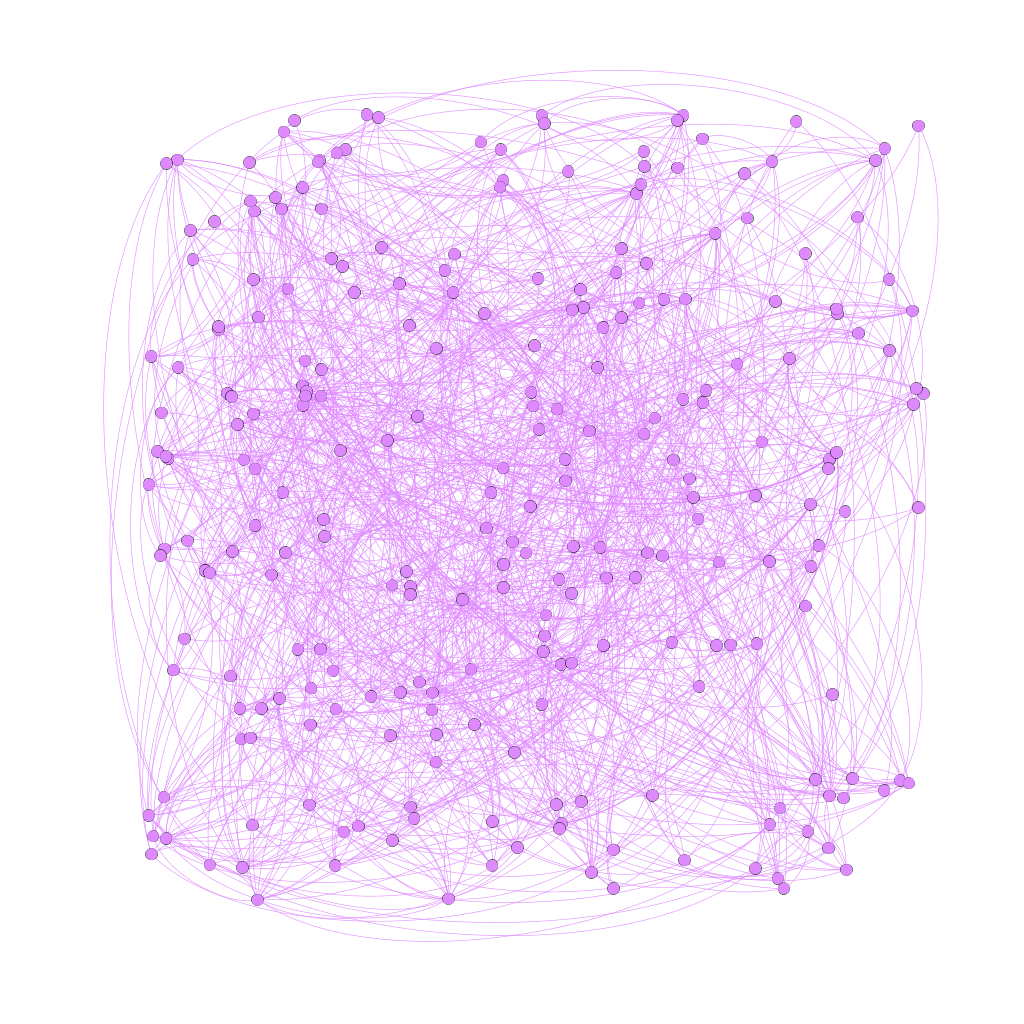

In [21]:
#hide_input
#Following is the picture of biggest modularity class (subgroup) and the associated data.
x = Image(filename = image_folder_path + "technology&innovation_module.png", width=250, height=250)
display(x)

### Calculate TF-IDF value of terms in ted talk transcripts
<ul>
    <li> We use Sklearn's (an ML library in Python) TfidfVectorizer </li>
    <li> It is important that stop words ('and', 'the' etc) are not counted therefore we pass parameter 'english' to remove english stop words. </li>
</ul>   

In [115]:
#collapse-show
tfidf_vector = TfidfVectorizer(stop_words='english')
tfidf_values = tfidf_vector.fit_transform(final_ted_df['transcript'])
tfidf_matrix = tfidf_values.toarray()
# some of the identified features/terms from transcripts
print("TFIDF vectorizer has identified {} unique tokens in all the transcripts data.".format(tfidf_matrix.shape[1]))
print("Following are some of the identified tokens:")
print(tfidf_vector.get_feature_names()[5000:5025])

TFIDF vectorizer has identified 58489 unique tokens in all the transcripts data.
Following are some of the identified tokens:
['baldness', 'baldwin', 'baldy', 'bale', 'baleen', 'baleful', 'balenciaga', 'balers', 'bales', 'balfour', 'bali', 'balikpapan', 'balinese', 'balk', 'balkan', 'balkans', 'balked', 'balkh', 'balkhi', 'ball', 'ballads', 'ballah', 'ballard', 'ballast', 'ballasted']


### Search query

In [31]:
 
search_query = "inspiration and courage"

### Create matching score based on search query terms
<ul>
    <li>Matching score of a ted talk - it is the sum of all TF-IDF values for terms in search query </li>
</ul>   

In [110]:
#collapse-show
search_tokens = search_query.split(" ")
# Find the index of all search tokens in feature names obtained from TFIDF vectorizer.
feature_names = tfidf_vector.get_feature_names()
token_indexes = list()
for token in search_tokens:
    if token in feature_names:
        index = feature_names.index(token)
        token_indexes.append(index)
if len(token_indexes) == 0:
    # No search term found in the feature names. Return no results.
    print("No keywords in our data match with the query")
else:
    matching_scores = np.zeros(2467)
    for index in token_indexes:
        matching_scores = np.add(matching_scores, tfidf_matrix[:,index])

search_dataframe = final_ted_df[['title','url', 'eigenvector_value']]
search_dataframe = search_dataframe.assign(matching_scores=matching_scores)
print("Notice the matching_scores column for the above specified search query:")
search_dataframe.head(5)

Notice the matching_scores column for the above specified search query:


,title,url,eigenvector_value,matching_scores
0,Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_schools_kill_creativity\n,0.003404,0.000000
1,Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_climate_crisis\n,0.001041,0.000000
2,Simplicity sells,https://www.ted.com/talks/david_pogue_says_simplicity_sells\n,0.000441,0.000000
3,Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale_of_urban_renewal\n,0.001574,0.017196
4,The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_the_best_stats_you_ve_ever_seen\n,0.001933,0.000000


### Total Score : Combine Eigen-vector and Matching score values to create a composite score
<ul>
    <li>We give equal weightage to eigenvector value and matching score and calculate a composite score for each ted talk and sort to get top 5 search results</li>
</ul>   

In [111]:
#collapse-show
search_dataframe['total_score'] = 0.5 * search_dataframe['matching_scores'] + 0.5 * search_dataframe['eigenvector_value']
print("We have calculated a composite total score for each ted talk. Notice the total_Score column:")
search_dataframe.head(5)

We have calculated a composite total score for each ted talk. Notice the total_Score column:


,title,url,eigenvector_value,matching_scores,total_score
0,Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_schools_kill_creativity\n,0.003404,0.000000,0.001702
1,Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_climate_crisis\n,0.001041,0.000000,0.000521
2,Simplicity sells,https://www.ted.com/talks/david_pogue_says_simplicity_sells\n,0.000441,0.000000,0.000220
3,Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale_of_urban_renewal\n,0.001574,0.017196,0.009385
4,The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_the_best_stats_you_ve_ever_seen\n,0.001933,0.000000,0.000966


### Search results (top 5)
<ul>
<li>Search results are <i>"Courage is contagious", "Its time for women to run for office"</i> etc and appear quite relevant to our search query - 'inspiration and courage'</li> 
<li>If we check the transcript of these talks they have lot of words like inspiration, courage or both leading to high TF-IDF values</li> 
<li>Also, these talks are more recommended in other important talks and therefore have high eigenvector values.</li>
</ul>

In [113]:
#collapse-show
# Show the top 5 search results
search_dataframe.sort_values(['total_score'], ascending=[False], inplace = True)
print("Following are the top 5 search results:")
search_dataframe.head(5)[['title','url']]

Following are the top 5 search results:


,title,url
2426,Courage is contagious,https://www.ted.com/talks/damon_davis_what_i_saw_at_the_ferguson_protests\n
1681,"I'm not your inspiration, thank you very much",https://www.ted.com/talks/stella_young_i_m_not_your_inspiration_thank_you_very_much\n
2239,It's time for women to run for office,https://www.ted.com/talks/halla_tomasdottir_it_s_time_for_women_to_run_for_office\n
2196,A new way to heal hearts without surgery,https://www.ted.com/talks/franz_freudenthal_a_new_way_to_heal_hearts_without_surgery\n
800,The power of vulnerability,https://www.ted.com/talks/brene_brown_on_vulnerability\n


### Shortcomings
- Matching score metric doesn't work well with long search queries. Need to look into cosine similarity metric.
- Using eigenvector metric instead of pagerank
- No contextual understanding of the query.

 So we have implemented a basic search engine in Python. I will be improving on it in further blog posts.  If you have any comments or suggestions please post below or tweet to me at - https://twitter.com/kn_neeraj or on <a href="https://www.linkedin.com/in/neerajkumar89/">LinkedIn</a>